In [2]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
%matplotlib inline
### imports ###
import sys
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

# import custom functions
sys.path.insert(0, '/home/h1bennet/code/')
from homer_preprocessing import import_homer_diffgene, read_homer_gene_exp
from plotting_scripts import plot_exp_rpkm, gene_list_bar_plot

In [3]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['savefig.dpi'] = 500


# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####

In [4]:
workingDirectory = '/home/h1bennet/strains_rna/results/A10_Manuscript_Figures_AllLiverCells//'
dataDirectory = '/home/h1bennet/strains_rna/results/A00_Strains_Control_WholeLiver_RNA/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


Goal is easy visualization of gene expression across hepatic cell types.

# Extract differential genes 

In [5]:
strains = ['aj', 'balbc', 'c57']
cells = ['hepatocyte', 'kupffer', 'lsec', 'stellate']
log2fc = 1
padj = 0.05
gene_list_dict ={}

In [6]:
for strain in strains:
    for cell in cells:
        strain_cell = strain+'_'+cell
        # initialize gene lists
        g_intersect = set()
        g_union = set()
        for i in glob.glob(dataDirectory+'/differential/'+strain_cell+'*homer.txt'):
            print(i)
            # read in gene expression data
            df, tpm, tpm_mat, tpm_mat_quant = import_homer_diffgene(
                depath=i,
                gepath=dataDirectory+'/expression/HOMER.rawTPM.txt',
                gene_name_index=True)

            # select differential genes
            df = df.loc[~(df.chr.str.contains('chrX|chrY|ChrUn')), :]
            sig_genes = df.index[(df['padj'] < padj) & (df['log2FoldChange'] <= -log2fc)].to_list()

            # add to sets
            if len(g_union) == 0:
                g_union = set(sig_genes)
                g_intersect = set(sig_genes)
            else:
                g_union = g_union.union(sig_genes)
                g_intersect = g_intersect.intersection(sig_genes)

            # print('union set length:', print(len(g_union)))
            # print('intersection set length:', print(len(g_intersect)))

        # after getting union and intersection sets add to dict
        gene_list_dict[strain_cell+'_union'] = list(g_union)
        gene_list_dict[strain_cell+'_intersection'] = list(g_intersect)
        

/home/h1bennet/strains_rna/results/A00_Strains_Control_WholeLiver_RNA//differential/aj_hepatocyte_control_young.vs.balbc_hepatocyte_control_young.scatter.homer.txt
ge all transcripts (24940, 43)
Diff Gene selected transcripts (5501, 14)
ge selected transcripts (5501, 43)
/home/h1bennet/strains_rna/results/A00_Strains_Control_WholeLiver_RNA//differential/aj_hepatocyte_control_young.vs.c57_hepatocyte_control_young.scatter.homer.txt
ge all transcripts (24940, 43)
Diff Gene selected transcripts (5494, 14)
ge selected transcripts (5494, 43)
/home/h1bennet/strains_rna/results/A00_Strains_Control_WholeLiver_RNA//differential/aj_kupffer_control_young.vs.c57_kupffer_control_young.scatter.homer.txt
ge all transcripts (24940, 43)
Diff Gene selected transcripts (7652, 14)
ge selected transcripts (7652, 43)
/home/h1bennet/strains_rna/results/A00_Strains_Control_WholeLiver_RNA//differential/aj_kupffer_control_young.vs.balbc_kupffer_control_young.scatter.homer.txt
ge all transcripts (24940, 43)
Diff 

# Heatmap of ligand expression

In [7]:
if not os.path.isdir('./fancy_figures/'):
    os.mkdir('./fancy_figures/')

### Read in nichenet ligands

In [8]:
ligands = pd.read_csv('/home/h1bennet/data/gene_lists/nichenet_ligands.txt',
                      sep='\t')['x'].str.capitalize().tolist()
ligands[:5]

['Cxcl1', 'Cxcl2', 'Cxcl3', 'Cxcl5', 'Ppbp']

In [9]:
receptors = pd.read_csv(
    '/home/h1bennet/data/gene_lists/nichenet_receptors.csv')['to'].str.capitalize().tolist()
receptors[:5]

['Cxcr2', 'Cxcr1', 'Cxcr3', 'Cxcr4', 'Cxcr5']

### Read in expression values

In [10]:
tpm_mat = pd.read_csv('../A00_Strains_Control_WholeLiver_RNA/expression/rawT.txt', sep='\t', index_col=0)

### pull average expression

In [11]:
avg_tpm_dict = {}
for strain in strains:
    for cell in cells:
        strain_cell = strain+'_'+cell
        avg = tpm_mat.loc[:, tpm_mat.columns.str.contains(strain_cell)].mean(1)
        avg_tpm_dict[strain_cell] = avg

In [12]:
avg_tpm_df = pd.DataFrame(avg_tpm_dict)

In [13]:
avg_tpm_df.columns

Index(['aj_hepatocyte', 'aj_kupffer', 'aj_lsec', 'aj_stellate',
       'balbc_hepatocyte', 'balbc_kupffer', 'balbc_lsec', 'balbc_stellate',
       'c57_hepatocyte', 'c57_kupffer', 'c57_lsec', 'c57_stellate'],
      dtype='object')

set order manually

In [14]:
reorder_cols = ['aj_hepatocyte', 'balbc_hepatocyte', 'c57_hepatocyte',
                'aj_kupffer','balbc_kupffer','c57_kupffer',
                'aj_lsec','balbc_lsec','c57_lsec',
                'aj_stellate','balbc_stellate','c57_stellate']

In [15]:
avg_tpm_df = avg_tpm_df.loc[:, reorder_cols]

In [16]:
avg_tpm_df.to_csv('./hepatic_cells_average_tpm.txt',
                  sep='\t')

# Kupffer plots with union gene set for kupffer cells

In [17]:
avg_tpm_df_kup = avg_tpm_df.loc[:, avg_tpm_df.columns.str.contains('kupffer')]

In [18]:
act = []
for key in gene_list_dict.keys():
    if ('union' in key) and ('kupffer' in key):
        act.extend(gene_list_dict[key])

act = set(act)
# overlap with ligands
act_receptors = act.intersection(receptors)
print(len(act), 'activated genes')
print(len(act_receptors), 'activated receptors')

525 activated genes
37 activated receptors


In [19]:
# cluster targets
import scipy
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist

tmp_mat = np.log2(avg_tpm_df_kup.loc[act_receptors]+1)

d1 = dist.pdist(tmp_mat)
D1 = dist.squareform(d1)
Y1 = sch.linkage(D1, method='average', metric='euclidean') ### array-clustering metric - 'average', 'single', 'centroid', 'complete'
Z1 = sch.dendrogram(Y1, no_plot=True)

/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/ipykernel_launcher.py:10: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  # Remove the CWD from sys.path while we load stuff.


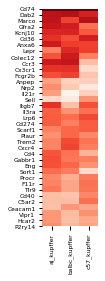

In [20]:
f, ax = plt.subplots(1, figsize=(1,4))
sns.heatmap(
    tmp_mat.iloc[Z1['leaves'], :],
#     cbar_kws={'orientation':'horizontal',
#               'label': 'Log2(TPM+1)'},
    vmin=0,
    vmax=10,
    cbar=False,
    # cbar_ax=cbar_ax,
    cmap='Reds',
    yticklabels=1,
    ax=ax)

plt.savefig('./fancy_figures/diff_expressed_receptors_avg_exp_no_cbar.pdf', bbox_inches='tight')


# Union gene set

In [21]:
avg_tpm_df_filt = avg_tpm_df.loc[:, ~avg_tpm_df.columns.str.contains('kupffer')]

In [22]:
act = []
for key in gene_list_dict.keys():
    if ('union' in key) and ('kupffer' not in key):
        act.extend(gene_list_dict[key])

act = set(act)
# overlap with ligands
act_ligands = act.intersection(ligands)
print(len(act), 'activated genes')
print(len(act_ligands), 'activated ligands')

1931 activated genes
88 activated ligands


In [23]:
# cluster targets
import scipy
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist

tmp_mat = np.log2(avg_tpm_df_filt.loc[act_ligands]+1)

d1 = dist.pdist(tmp_mat)
D1 = dist.squareform(d1)
Y1 = sch.linkage(D1, method='average', metric='euclidean') ### array-clustering metric - 'average', 'single', 'centroid', 'complete'
Z1 = sch.dendrogram(Y1, no_plot=True)

/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/ipykernel_launcher.py:10: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  # Remove the CWD from sys.path while we load stuff.


## Pot without colorbar

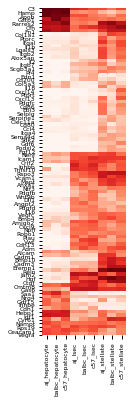

In [24]:
f, ax = plt.subplots(1, figsize=(1.5,6))
sns.heatmap(
    tmp_mat.iloc[Z1['leaves'], :],
#     cbar_kws={'orientation':'horizontal',
#               'label': 'Log2(TPM+1)'},
    vmax=10,
    cbar=False,
    # cbar_ax=cbar_ax,
    cmap='Reds',
    yticklabels=1,
    ax=ax)

plt.savefig('./fancy_figures/diff_expressed_ligands_no_cbar.pdf', bbox_inches='tight')


# Plot without colorbar or tick labels

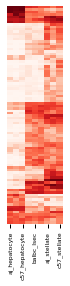

In [33]:
f, ax = plt.subplots(1, figsize=(1, 4))
sns.heatmap(
    tmp_mat.iloc[Z1['leaves'], :],
#     cbar_kws={'orientation':'horizontal',
#               'label': 'Log2(TPM+1)'},
    vmax=10,
    cbar=False,
    # cbar_ax=cbar_ax,
    cmap='Reds',
    yticklabels=0,
    ax=ax)

plt.savefig('./fancy_figures/diff_expressed_ligands_no_cbar_noticks.pdf', bbox_inches='tight')


# Plot with colorbar

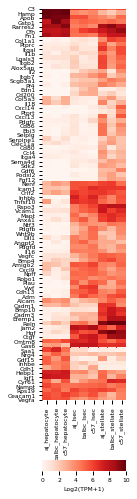

In [26]:
grid_kws = {"height_ratios": (.9, .025,), "hspace": .3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(1.5,8.5))
sns.heatmap(
    tmp_mat.iloc[Z1['leaves'], :],
    cbar_kws={'orientation':'horizontal',
              'label': 'Log2(TPM+1)'},
    vmax=10,
    cbar_ax=cbar_ax,
    cmap='Reds',
    yticklabels=1,
    ax=ax)

plt.savefig('./fancy_figures/diff_expressed_ligands.pdf', bbox_inches='tight')


# Plot colorbar

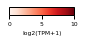

In [32]:
fig, ax = plt.subplots(figsize=(2,1))

cmap = matplotlib.cm.Reds
norm = matplotlib.colors.Normalize(vmin=0, vmax=10)
plt.gca().set_visible(False)
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm,  cmap=cmap),
                  use_gridspec=True,
                  orientation='horizontal',
                  label='log2(TPM+1)',
                  aspect=8)
plt.savefig('./fancy_figures/colorbar.pdf',
            bbox_inches='tight')

# Plot each cell type independently...

In [76]:
tmp_mat

,aj_hepatocyte,balbc_hepatocyte,c57_hepatocyte


In [79]:
act

set()

hepatocyte
590 activated genes
12 activated ligands
kupffer
525 activated genes
26 activated ligands


/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/ipykernel_launcher.py:19: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


lsec
497 activated genes
22 activated ligands
stellate
1249 activated genes
70 activated ligands


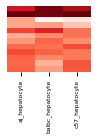

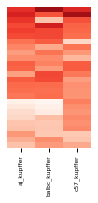

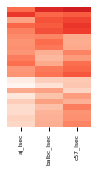

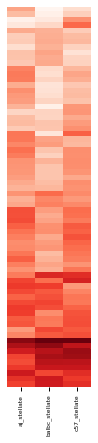

In [88]:
for cell in ['hepatocyte', 'kupffer', 'lsec', 'stellate']:
    print(cell)
    act = []
    for key in gene_list_dict.keys():
        if ('union' in key) and (cell in key):
            act.extend(gene_list_dict[key])

    act = set(act)
    # overlap with ligands
    act_ligands = act.intersection(ligands)
    print(len(act), 'activated genes')
    print(len(act_ligands), 'activated ligands')
    
    tmp_mat = np.log2(avg_tpm_df.loc[act_ligands]+1)
    tmp_mat = tmp_mat.loc[:, tmp_mat.columns.str.contains(cell)]

    d1 = dist.pdist(tmp_mat)
    D1 = dist.squareform(d1)
    Y1 = sch.linkage(D1, method='average', metric='euclidean') ### array-clustering metric - 'average', 'single', 'centroid', 'complete'
    Z1 = sch.dendrogram(Y1, no_plot=True)
    
    f, ax = plt.subplots(1, figsize=(1.5,len(act_ligands)/10))
    sns.heatmap(
        tmp_mat.iloc[Z1['leaves'], :],
        #     cbar_kws={'orientation':'horizontal',
        #               'label': 'Log2(TPM+1)'},
        vmax=10,
        cbar=False,
        # cbar_ax=cbar_ax,
        cmap='Reds',
        yticklabels=0,
        ax=ax)
    
    plt.savefig('./fancy_figures/%s_expressed_receptors_no_cbar_noticks.pdf' % cell,
                bbox_inches='tight')
